## Continuation of 2.5a_Activation_Maximization_and_Attribution_Vis.ipynb

Due to script crashing...

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import load_model

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # display multiple outputs

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
model_D8 = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/MNIST_with_Keras/MNIST_models/model_D8')
model_D128 = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/MNIST_with_Keras/MNIST_models/model_D128')
model_overfit = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/MNIST_with_Keras/MNIST_models/model_overfit')
model3 = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/MNIST_with_Keras/MNIST_models/model3')
model4 = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/MNIST_with_Keras/MNIST_models/model4')
model5 = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/MNIST_with_Keras/MNIST_models/model5')
model5a = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/MNIST_with_Keras/MNIST_models/model5a')
model5b = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/MNIST_with_Keras/MNIST_models/model5b')
model5c = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/MNIST_with_Keras/MNIST_models/model5c')
model6 = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/MNIST_with_Keras/MNIST_models/model6')
model7 = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/MNIST_with_Keras/MNIST_models/model7')

### What do ConvNets see? Visualizing filters with Activation Maximization

https://www.machinecurve.com/index.php/2019/12/03/what-do-convnets-see-visualizing-filters-with-activation-maximization/

https://keras.io/examples/vision/visualizing_what_convnets_learn/

In [10]:
img_width = 28
img_height = 28
layer_name = "conv2d"

In [11]:
# Set up a model that returns the activation values for our target layer
layer = model5.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model5.inputs, outputs=layer.output)

In [12]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [13]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [14]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 1))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    # img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [17]:
from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.png", img)

In [18]:
Image("0.png",width=300,height=300)

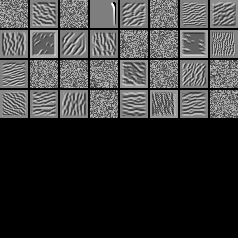

In [19]:
# Compute image inputs that maximize per-filter activations
# for the 32 filters of our target layer
all_imgs = []
for filter_index in range(32):
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 2
n = 8
cropped_width = img_width - 0 * 2
cropped_height = img_height - 0 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 1))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
      if (i*n)+j<32:
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

Image("stiched_filters.png",width=1000,height=1000)

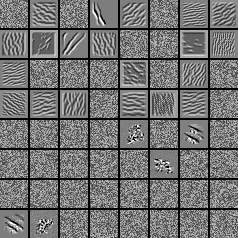

In [20]:
layer_name = "conv2d_1"

layer = model5.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model5.inputs, outputs=layer.output)

# Compute image inputs that maximize per-filter activations
# for the 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 2
n = 8
cropped_width = img_width - 0 * 2
cropped_height = img_height - 0 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 1))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
      #if (i*n)+j<32:
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

Image("stiched_filters.png",width=1000,height=1000)